# Работа с уменьшенныч датасетом Omniglot

---



# Загрузка уменьшенного датасета Omniglot

Загрузка датасета

In [1]:
from sklearn.metrics import accuracy_score
from google.colab import drive
import numpy as np
import os

drive.mount('/content/drive')

PATH = 'drive/My Drive/Few-Shot-Learning/Omniglot-data-set'

RANDOM_STATE = 17

NUMBER_OF_CLASSES = 100

X_train_r = np.loadtxt(os.path.join(PATH, 'train_images.txt'), dtype=np.uint8)
y_train_r = np.loadtxt(os.path.join(PATH, 'train_labels.txt'), dtype='str')

X_train_r = np.resize(X_train_r, (NUMBER_OF_CLASSES * 14, 105 * 105))
y_train_r = np.resize(y_train_r, (NUMBER_OF_CLASSES * 14))

X_test_r = np.loadtxt(os.path.join(PATH, 'test_images.txt'), dtype=np.uint8)
y_test_r = np.loadtxt(os.path.join(PATH, 'test_labels.txt'), dtype='str')

X_test_r = np.resize(X_test_r, (NUMBER_OF_CLASSES * 6, 105 * 105))
y_test_r = np.resize(y_test_r, (NUMBER_OF_CLASSES * 6))

Mounted at /content/drive


Определение тензоров

In [3]:
import torch

train_images = torch.from_numpy(np.array(X_train_r / 128 - 1).reshape(14 * NUMBER_OF_CLASSES, 1, 105, 105)).float()
test_images = torch.from_numpy(np.array(X_test_r / 128 - 1).reshape(6 * NUMBER_OF_CLASSES, 1, 105, 105)).float()

classes = [y_train_r[14 * i] for i in range(NUMBER_OF_CLASSES)]

train_labels = torch.from_numpy(np.array([np.array([i]) for i in range(NUMBER_OF_CLASSES) for _ in range(14)])).long()
test_labels = torch.from_numpy(np.array([np.array([i]) for i in range(NUMBER_OF_CLASSES) for _ in range(6)])).long()

Определение вспомогательной функции для подготовки выборки

In [14]:
import random

def shuffle_tensor(tensor, batch_size):
  random.shuffle(tensor)

  images, labels = zip(*tensor)

  images = torch.stack(images[:])
  labels = torch.stack(labels[:])

  images = images.view(14 * NUMBER_OF_CLASSES // batch_size, batch_size, 1, 105, 105).float()
  labels = labels.view(14 * NUMBER_OF_CLASSES // batch_size, batch_size).long()

  return list(zip(images, labels))


# Визуализация датасета Omniglot (уменьшенный датасет)

label: Armenian_05


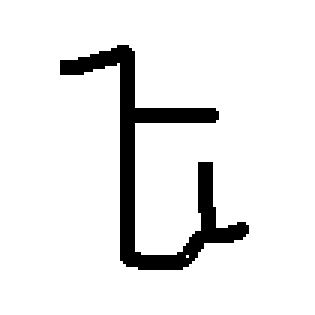

In [5]:
from PIL import Image

digit_number = -1

image = Image.fromarray(X_train_r[digit_number].reshape(105, 105), mode='P')

print('label: {}'.format(y_train_r[digit_number]))
display(image.resize((315, 315)))

# Использование полносвязной нейронной сети для решения задачи классификации рукописных символов (уменьшенный датасет)

Создание полносвязной нейронной сети

In [59]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.drop = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(105 * 105, 1000)
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 100)

  def forward(self, x):
    x = x.view(-1, 105 * 105)
    x = F.relu(self.drop(self.fc1(x)))
    x = F.relu(self.drop(self.fc2(x)))
    x = self.fc3(x)
    return x


Обучение полносвязной нейронной сети

In [60]:
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for iteration in range(100):
  trainset = shuffle_tensor(list(zip(train_images, train_labels)), 25)

  for data in trainset:
    images, labels = data

    optimizer.zero_grad()

    labels_pred = net(images.unsqueeze(0))
    loss = criterion(labels_pred, labels)

    loss.backward()
    optimizer.step()


Использование полносвязной нейронной сети

In [61]:
labels_pred = net(test_images)
_, predicted = torch.max(labels_pred, 1)

Вычисление метрик

In [62]:
print('accuracy {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted.detach().numpy())))

accuracy 0.512


# Использование сверточной нейронной сети для решения задачи классификации рукописных символов (уменьшенный датасет)

Создание сверточной нейронной сети

In [52]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.drop = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(32 * 24 * 24, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 32 * 24 * 24)
    x = F.relu(self.drop(self.fc1(x)))
    x = self.fc2(x)
    return x


Обучение сверточной нейронной сети

In [56]:
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for iteration in range(50):
  trainset = shuffle_tensor(list(zip(train_images, train_labels)), 25)

  for data in trainset:
    images, labels = data

    optimizer.zero_grad()

    labels_pred = net(images)
    loss = criterion(labels_pred, labels)

    loss.backward()
    optimizer.step()


Использование сверточной нейронной сети

In [57]:
labels_pred_s = net(test_images)
_, predicted_s = torch.max(labels_pred_s, 1)

Вычисление метрик

In [58]:
print('accuracy {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted_s.detach().numpy())))

accuracy 0.548


# Сравнение результатов работы нейронных сетей с классическими методами машинного обучения для датасета Omniglot (уменьшенный датасет)

In [64]:
from sklearn.metrics import accuracy_score

print('Neural network              : {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted.detach().numpy())))
print('Convolutional Neural network: {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted_s.detach().numpy())))

Neural network              : 0.512
Convolutional Neural network: 0.548


При использовании нейронных сетей заметно увеличился показатель accuracy. Если при использовании классических методов машинного обучения максимальный показатель был 42% (метод логистической регрессии и метод случайного леса), то тут он заметно возрос и перешагнул за половину. Следует ответить, что при дополнительной настройке параметров и выборе может иной архитектуры можно добиться лучших показателей, но это лучше делать в совокупности с аугментацией выборки и использовании может еще более хитрых конструкций, что и будет дальнейшим развитием данного проекта. Если сравнивать полносвязную нейронную сеть и сверточную нейронную сеть, то следует отметить скорость обучения. В моем случае для достижения лучшего результата сверточной нейронной сети потребовалось в два раза меньше эпох. Архитектура выбиралась хоть и по большей части эмпирически, но отлично себя показала, не смотря на сложность данного датасета: малое количество объектов обучающей выборки при большом числе классов.